<a href="https://colab.research.google.com/github/carlosmvond/hybrid-modelling-of-batch-bioreactors/blob/main/Application1_Martinez_et_al_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This first code block is used to generate synthetic data using the model developed by Mauri et al. (2020). It is important to note that we consider the version of the model without recombinant protein production.

Mauri, M., Gouzé, J. L., De Jong, H., & Cinquemani, E. (2020). Enhanced production of heterologous proteins by a synthetic microbial community: Conditions and trade-offs. PLOS Computational Biology, 16(4), e1007795.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# === Model parameters (batch, Yh = 0) ===
kg      = 1.53
Kg      = 0.09
Theta_a = 0.52
n       = 1
k_over  = 0.17
l       = 0.7
ka      = 0.97
Ka      = 0.5
Theta_g = 0.25
m_CCR   = 1
Yg      = 0.44
Ya      = 0.298
kdeg    = 0.0044

# === Kinetics ===
def r_gup(G, A):
    """Glucose uptake rate."""
    return kg * G/(G + Kg) * (Theta_a**n)/(A**n + Theta_a**n)

def r_a_up(G, A):
    """Acetate uptake rate with CCR."""
    return ka * A/(A + Ka) * 1/(1 + (r_gup(G, A)/Theta_g)**m_CCR)

def r_a_over(G, A):
    """Overflow acetate production when glucose uptake exceeds threshold l."""
    return k_over * max(0, r_gup(G, A) - l)

# === Batch model ODEs ===
def ode_batch(t, y):
    """
    States:
      X: biomass
      G: glucose
      A: acetate
    """
    X, G, A = y
    rg  = r_gup(G, A)
    rau = r_a_up(G, A)
    ro  = r_a_over(G, A)
    dX = (Yg*rg + Ya*(rau - ro)) * X - kdeg * X
    dG = - rg * X
    dA = (ro - rau) * X
    return [dX, dG, dA]

# === Generate "clean" synthetic data ===
time_points = np.linspace(0, 15, 10)
initial_glucose = [10, 20, 35, 50]
X0 = 0.1

raw_t, raw_X, raw_G, raw_A = [], [], [], []

for G0 in initial_glucose:
    sol = solve_ivp(
        ode_batch,
        (time_points[0], time_points[-1]),
        [X0, G0, 0.0],
        t_eval=time_points
    )
    raw_t.append(sol.t.tolist())
    raw_X.append(sol.y[0].tolist())
    raw_G.append(sol.y[1].tolist())
    raw_A.append(sol.y[2].tolist())

# === Configurable multiplicative noise ===
# Coefficient of variation (relative std): typically 0.02–0.2
cv_X = 0.05  # biomass
cv_G = 0.05  # glucose
cv_A = 0.05  # acetate

# Factor for t = 0 (use <1.0 to reduce noise on initial conditions)
init_scale = 0.5  # 0.5 = half the noise on the first point; use 1.0 for the same as others

rng = np.random.default_rng(12345)

def add_multiplicative_noise(series_2d, cv, init_scale=1.0, clip_min=0.0):
    """
    Apply y_obs = y * (1 + N(0, cv)) pointwise.
    The first point is scaled by 'init_scale' to optionally reduce initial noise.
    """
    out = []
    for row in series_2d:
        row = np.asarray(row, dtype=float)
        eps = rng.normal(0.0, cv, size=row.shape)
        eps[0] *= init_scale
        y_obs = row * (1.0 + eps)
        if clip_min is not None:
            y_obs = np.maximum(y_obs, clip_min)
        out.append(y_obs.tolist())
    return out

# Observed data with multiplicative noise
obs_X = add_multiplicative_noise(raw_X, cv_X, init_scale=init_scale, clip_min=0.0)
obs_G = add_multiplicative_noise(raw_G, cv_G, init_scale=init_scale, clip_min=0.0)
obs_A = add_multiplicative_noise(raw_A, cv_A, init_scale=init_scale, clip_min=0.0)

# === Utility: pretty-print 2D lists ===
def print_list(name, data):
    print(f"{name} = [")
    for row in data:
        print("    [" + ", ".join(f"{x:.4f}" for x in row) + "],")
    print("]\n")

# Print noisy data (switch to raw_* if you want clean data)
print_list("raw_t", raw_t)
print_list("obs_X", obs_X)
print_list("obs_G", obs_G)
print_list("obs_A", obs_A)


raw_t = [
    [0.0000, 1.6667, 3.3333, 5.0000, 6.6667, 8.3333, 10.0000, 11.6667, 13.3333, 15.0000],
    [0.0000, 1.6667, 3.3333, 5.0000, 6.6667, 8.3333, 10.0000, 11.6667, 13.3333, 15.0000],
    [0.0000, 1.6667, 3.3333, 5.0000, 6.6667, 8.3333, 10.0000, 11.6667, 13.3333, 15.0000],
    [0.0000, 1.6667, 3.3333, 5.0000, 6.6667, 8.3333, 10.0000, 11.6667, 13.3333, 15.0000],
]

obs_X = [
    [0.0964, 0.2917, 0.6666, 1.5951, 3.4965, 4.2735, 4.1042, 4.5152, 4.4197, 3.8888],
    [0.1059, 0.2888, 0.6755, 1.7068, 3.4866, 7.6150, 9.1119, 8.1553, 8.8872, 9.1752],
    [0.1033, 0.2718, 0.7362, 1.5068, 3.5601, 7.8789, 14.3132, 15.1707, 16.4257, 16.9762],
    [0.1019, 0.2876, 0.6714, 1.5430, 3.3414, 7.9336, 17.1850, 21.0737, 20.3033, 21.7507],
]

obs_G = [
    [10.0782, 9.5138, 9.1066, 6.3734, 2.0270, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
    [20.2168, 19.8451, 19.0419, 16.8014, 12.2575, 2.4536, 0.0000, 0.0000, 0.0000, 0.0000],
    [34.9376, 35.3918, 32.8489, 31.4996, 24.6445, 16.6497, 0.0000, 0.0000,

This code visualizes the synthetic batch data generated with the Mauri et al. (2020) model.
It produces a grid of plots showing the time evolution of biomass (X), glucose (G), and acetate (A) for each simulated batch experiment.

Each subplot corresponds to one batch, identified by its initial glucose concentration (G₀).

*   The left y-axis displays biomass (X) and glucose (G).
*   The right y-axis displays acetate (A).
*   Observed data (with noise) are shown with dashed lines and markers.

Global minimum and maximum values are computed so that all subplots share consistent axis limits, facilitating comparison across experiments.

The code automatically adjusts the figure layout and hides unused subplots if necessary.




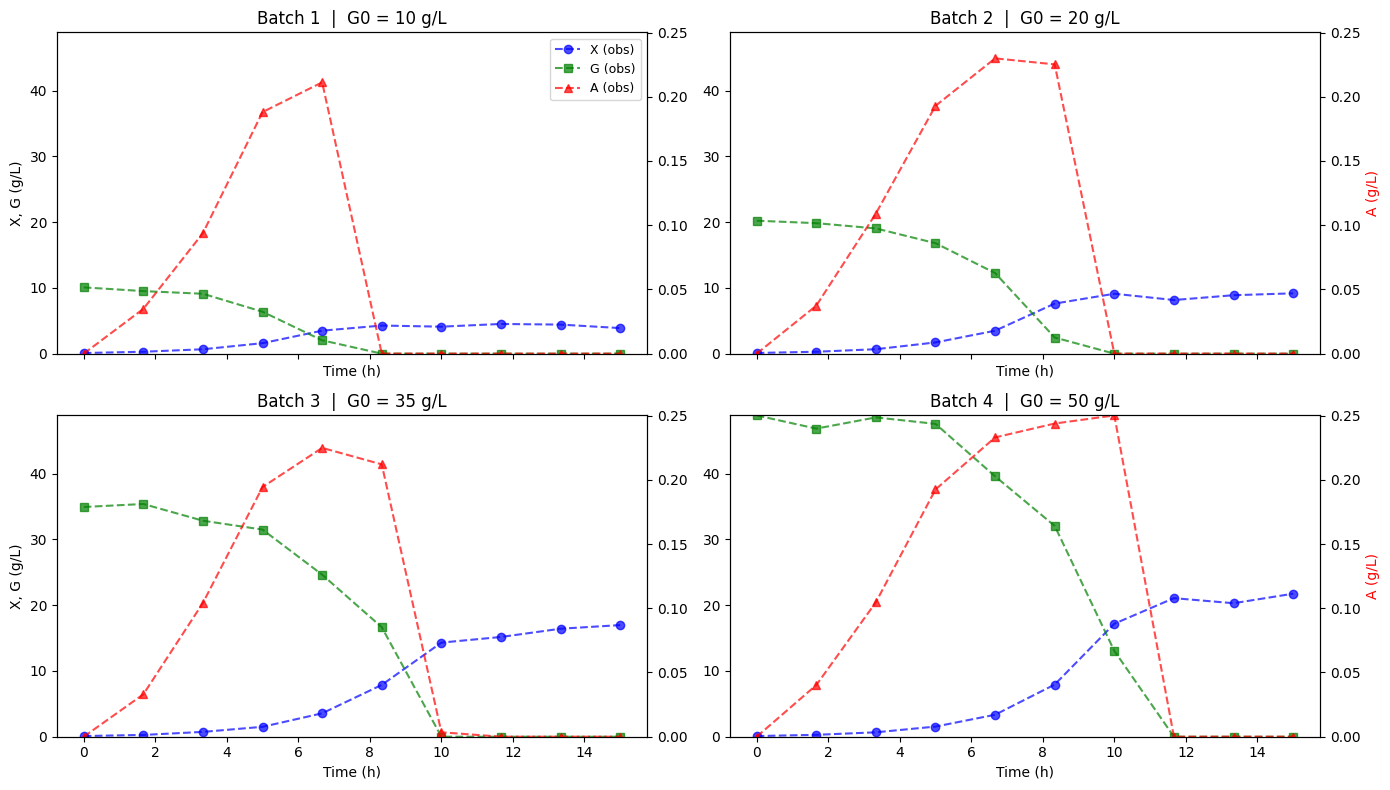

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# --- Compute global min/max for consistent y-axes ---
X_all = np.concatenate([np.array(x) for x in obs_X])
G_all = np.concatenate([np.array(g) for g in obs_G])
A_all = np.concatenate([np.array(a) for a in obs_A])

ymin_XG = min(X_all.min(), G_all.min())
ymax_XG = max(X_all.max(), G_all.max())

ymin_A = A_all.min()
ymax_A = A_all.max()

# --- Figure: 2 rows × 2 cols (4 batches) ---
n_batches = len(initial_glucose)
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True)
axes = axes.flatten()

for i, (G0, t, X_true, G_true, A_true, X_obs, G_obs, A_obs) in enumerate(
    zip(initial_glucose, raw_t, raw_X, raw_G, raw_A, obs_X, obs_G, obs_A)
):
    ax1 = axes[i]
    ax2 = ax1.twinx()

    # X (blue) and G (green) on left axis
    ax1.plot(t, X_obs, 'b--', marker='o', alpha=0.7, label='X (obs)')
    ax1.plot(t, G_obs, 'g--', marker='s', alpha=0.7, label='G (obs)')
    ax1.set_xlabel("Time (h)")
    ax1.set_ylim(ymin_XG, ymax_XG)
    if i % 2 == 0:  # first column
        ax1.set_ylabel("X, G (g/L)")

    # A (red) on right axis
    ax2.plot(t, A_obs, 'r--', marker='^', alpha=0.7, label='A (obs)')
    ax2.set_ylim(ymin_A, ymax_A)
    if i % 2 == 1:  # last column
        ax2.set_ylabel("A (g/L)", color='r')

    # Title with Batch number + G0
    ax1.set_title(f"Batch {i+1}  |  G0 = {G0} g/L")

    # Merge legends (only on first subplot to avoid clutter)
    if i == 0:
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right", fontsize=9)

# Hide any extra axes if present
for j in range(n_batches, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


### ⚙️ Hybrid model calibration

The following code trains the **hybrid model** to the synthetic data generated earlier.  

The model has the following structure:

$$
\begin{aligned}
\frac{dX}{dt} &= f_{1}(\cdot)\,X, \\[6pt]
\frac{dG}{dt} &= f_{2}(\cdot)\,G\,X, \\[6pt]
\frac{dA}{dt} &= \big(f_{3}(\cdot)\,A + g_{3}(\cdot)\big)\,X.
\end{aligned}
$$

The functions  $f_i$, $i=1,2,3$ and $g_3$ form the **output layer** of the neural network. The activation function in the output layer is the **identity** for $f_i$ and **ReLU** for \( g_3 \).

---

### 🔧 Algorithm configuration

The algorithm is configured at the beginning of the code.  
The main **hyperparameters and options** are defined at the start of the script:

- **TRAIN_MODE** (`"batch"` | `"global"`):  
  - `"batch"`: each batch experiment is treated as an independent mini-batch; parameters are updated multiple times per epoch.  
  - `"global"`: the loss from all batches is accumulated, and a single update is performed per epoch (equivalent to one large global batch).

- **LR** (learning rate):  
  Update step size for the Adam optimizer.  
  High values may destabilize training; low values may slow convergence.

- **NUM_EPOCHS:**  
  Number of complete passes through the training set.

- **DROPOUT_RATE_HIDDEN:**  
  Fraction of hidden neurons randomly turned off during training (standard dropout, disabled during evaluation).  
  Useful for regularization and, optionally, for estimating uncertainty via Monte Carlo dropout.

- **EPS:**  
  Small positive constant used to stabilize divisions in the loss function (prevents division by zero).  
  A typical value is \(10^{-8}\).

- **SEED:**  
  Master random seed for reproducibility (affects initialization and dropout masks).  
  It does not guarantee identical results across hardware, but reduces variability.

---

### 🧠 MLP architecture

Defined by `hidden_layers` and `layer_sizes` (e.g., `3-5-5-5-4`),  
where **3** is the input dimension, **4** is the output dimension,  
and the intermediate values correspond to the hidden layers.

---


[Init calib] step 0, loss=6.2988e-03
[Init calib] step 50, loss=2.7120e-04
[Init calib] step 100, loss=7.2887e-05
[Init calib] step 150, loss=2.1862e-05
[Init calib] step 200, loss=8.6609e-06
[Init calib] step 250, loss=4.2411e-06
[Init calib] step 300, loss=2.3142e-06
[Init calib] step 350, loss=1.3588e-06
[Init calib] step 400, loss=8.5829e-07
[Init calib] step 450, loss=5.9125e-07
[Init calib] step 500, loss=4.3448e-07
[Init calib] step 550, loss=3.7502e-07
[Init calib] step 600, loss=3.0669e-07
[Init calib] step 650, loss=2.4467e-07
[Init calib] step 700, loss=2.3217e-07
[Init calib] step 750, loss=1.9049e-07
[Init calib] step 800, loss=1.7045e-07
[Init calib] step 850, loss=1.4304e-07
[Init calib] step 900, loss=1.5098e-07
[Init calib] step 950, loss=1.2992e-07
[Batch] Epoch 50, train=1.409434, valid=1.496703
[Batch] Epoch 100, train=0.950776, valid=0.843772
[Batch] Epoch 150, train=0.583803, valid=0.381938
[Batch] Epoch 200, train=0.286815, valid=0.201001
[Batch] Epoch 250, train

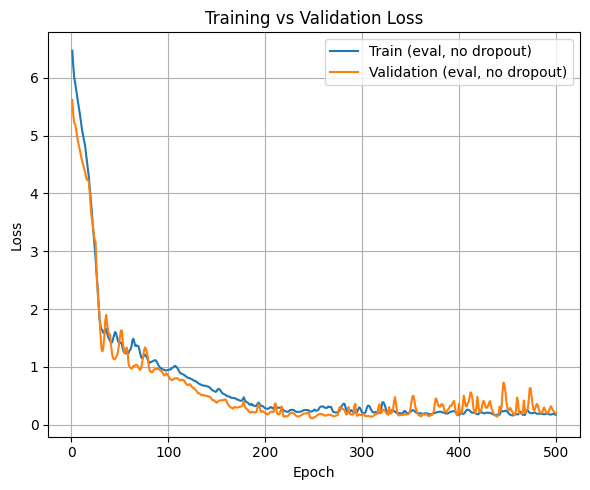


EXPERIMENT SUMMARY (Batch ODE + NN, ICs via log-offsets; A0=0 fixed)
Training mode              : batch
Epochs (config/actual)     : 500 / 500
Optimizer                  : Adam
Learning rate (LR)         : 0.001
Hidden dropout (rate)      : 0.1
MLP architecture           : 3-5-4  (hidden layers = 1)
# Total parameters         : 56  (includes net + IC offsets)
Seed (SEED)                : 1
# Batches (train/valid)    : 3 / 1
------------------------------------------------------------------------
Final loss     (train)     : 1.739274e-01
Final loss     (valid)     : 1.954467e-01
Best validation            : 1.118867e-01  (at epoch 249)
------------------------------------------------------------------------
Learned vs. measured ICs (train) (first point):
  Batch 01: X0_learn=0.2710 (meas=0.2571, alpha_X=+0.053), G0_learn=9.9115 (meas=10.0511, alpha_G=-0.014), A0_fixed=0.0000
  Batch 02: X0_learn=0.1446 (meas=0.1423, alpha_X=+0.016), G0_learn=19.6822 (meas=20.1694, alpha_G=-0.024), A0_f

In [9]:
import os
# 1) FORCE TPU FOR JAX (if you're not on TPU, comment these 3 lines)
from jax import config
config.update("jax_platform_name", "tpu")
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8"

import time
import jax
import jax.numpy as jnp
from jax.experimental.ode import odeint
import optax
import numpy as np
import matplotlib.pyplot as plt
from jax.lib import xla_bridge

# ========================================================
# 0. CONFIG: training mode and seed
# ========================================================
TRAIN_MODE = "batch"          # "batch" or "global"
LR = 1e-3                     # Learning rate (Adam)
NUM_EPOCHS = 500              # Number of epochs
DROPOUT_RATE_HIDDEN = 0.1     # Dropout in hidden layers (train only)
EPS = 1.0e-8                  # Avoid ~0 division in loss
SEED = 1                      # Master seed

hidden_layers = [5]
layer_sizes = [3] + hidden_layers + [4]  # input=[X,G,A] -> output=[f1,f2,f3,g3]

# Regularization of IC offsets (alpha_X, alpha_G ~ 0)
LAMBDA_IC = 1e0

rng_master = jax.random.PRNGKey(SEED)
np.random.seed(SEED)

# Indices (example: batches 0,1,3 for training; 2 for validation)
train_idxs = [0, 1, 3]
valid_idxs = [2]

# ========================================================
# 1. DATA PREP (raw_t, obs_X, obs_G, obs_A must already exist)
# ========================================================
t_batches = [jax.device_put(jnp.array(arr)) for arr in raw_t]
X_batches = [jax.device_put(jnp.array(arr)) for arr in obs_X]
G_batches = [jax.device_put(jnp.array(arr)) for arr in obs_G]
A_batches = [jax.device_put(jnp.array(arr)) for arr in obs_A]

t_train = [t_batches[i] for i in train_idxs]
X_train = [X_batches[i] for i in train_idxs]
G_train = [G_batches[i] for i in train_idxs]
A_train = [A_batches[i] for i in train_idxs]

t_valid = [t_batches[i] for i in valid_idxs]
X_valid = [X_batches[i] for i in valid_idxs]
G_valid = [G_batches[i] for i in valid_idxs]
A_valid = [A_batches[i] for i in valid_idxs]

# ========================================================
# 1.1 Helpers
# ========================================================
def count_params_pytree(pytree):
    """Count elements in a pytree (network + ICs)."""
    leaves, _ = jax.tree_util.tree_flatten(pytree)
    total = 0
    for l in leaves:
        if isinstance(l, (np.ndarray, jnp.ndarray)):
            total += int(np.prod(np.array(l.shape)))
        else:
            total += 1
    return total

def arch_string(layer_sizes):
    return "-".join(str(n) for n in layer_sizes)

# ========================================================
# 2. NEURAL NETWORK + HYBRID ODE (dropout in hiddens via masks)
# ========================================================
def init_net_params(rng_key, layer_sizes):
    """Initialize weights/biases with Uniform(-0.1, 0.1)."""
    params = {}
    keys = jax.random.split(rng_key, 2 * (len(layer_sizes) - 1))
    k = 0
    for i in range(len(layer_sizes) - 1):
        n_in, n_out = layer_sizes[i], layer_sizes[i + 1]
        params[f"W{i}"] = jax.random.uniform(keys[k], (n_out, n_in), minval=-0.1, maxval=0.1)
        params[f"b{i}"] = jax.random.uniform(keys[k + 1], (n_out,), minval=-0.1, maxval=0.1)
        k += 2
    return params

def sample_hidden_masks(net_params, rate, rng):
    """Inverted-dropout masks for hidden layers; constant during one ODE integration."""
    if rate is None or rate <= 0.0:
        return None
    keep = 1.0 - rate
    masks = []
    num_layers = len(net_params) // 2
    for i in range(num_layers - 1):  # hidden layers only
        size = net_params[f"b{i}"].shape
        rng, ki = jax.random.split(rng)
        mask = jax.random.bernoulli(ki, p=keep, shape=size)
        mask = mask.astype(jnp.float32) / keep
        masks.append(mask)
    return masks

def neural_network(net_params, y, *, train: bool = False, masks=None):
    """MLP with tanh hidden layers; linear output of size 4: [f1,f2,f3,g3]."""
    a = y
    num_layers = len(net_params) // 2
    for i in range(num_layers):
        W, b = net_params[f"W{i}"], net_params[f"b{i}"]
        z = W @ a + b
        if i < num_layers - 1:
            a = jnp.tanh(z)
            if train and (masks is not None):
                a = a * masks[i]
        else:
            a = z
    return a

def model_jax(net_params, y, t, *, train=False, masks=None):
    """Hybrid vector field; enforce non-negativity on g3 via ReLU."""
    X, G, A = y
    f1, f2, f3, g3 = neural_network(net_params, jnp.array([X, G, A]), train=train, masks=masks)
    g3_clamped = jax.nn.relu(g3)  # non-negative non-associated term
    return jnp.stack([f1 * X, f2 * G * X, f3 * A * X + g3_clamped * X])

def predict(net_params, t_array, X0, G0, *, A0=0.0, train=False, masks=None):
    """Integrate ODE from y0=[X0, G0, A0]; masks remain constant (no RNG inside)."""
    def rhs(y, tt):
        return model_jax(net_params, y, tt, train=train, masks=masks)
    y0 = jnp.array([X0, G0, A0])
    sol = odeint(rhs, y0, t_array)
    return sol[:, 0], sol[:, 1], sol[:, 2]

predict = jax.jit(predict, static_argnames=("train",))

# ========================================================
# 2.1 IC via LOG-OFFSETS (per TRAIN batch)
#     X0 = X0_meas * exp(alpha_X),  G0 = G0_meas * exp(alpha_G),  A0 = 0
# ========================================================
def init_ic_offset_params_from_data(X_train, G_train):
    """Create trainable 'alpha_X' and 'alpha_G' (initially 0) per TRAIN batch."""
    n = len(X_train)
    X0_meas = jnp.array([float(np.array(X_train[i])[0]) for i in range(n)])
    G0_meas = jnp.array([float(np.array(G_train[i])[0]) for i in range(n)])
    ic_alpha = {"alpha_X": jnp.zeros_like(X0_meas), "alpha_G": jnp.zeros_like(G0_meas)}
    ic_meas  = {"X0": X0_meas, "G0": G0_meas}
    return ic_alpha, ic_meas

def ic_for_train_batch(params, idx):
    """Return ICs for batch idx using the learned offsets."""
    X0_meas = params["ic_meas"]["X0"][idx]
    G0_meas = params["ic_meas"]["G0"][idx]
    alpha_X = params["ic_alpha"]["alpha_X"][idx]
    alpha_G = params["ic_alpha"]["alpha_G"][idx]
    X0 = X0_meas * jnp.exp(alpha_X)
    G0 = G0_meas * jnp.exp(alpha_G)
    A0 = jnp.array(0.0)
    return X0, G0, A0

# ========================================================
# 3. LOSSES
# ========================================================
def safe_rel(pred, obs):
    denom = jnp.maximum(jnp.mean(jnp.abs(obs)), EPS)
    return (pred - obs) / denom

def ic_reg_term(params, idx, lambda_ic=LAMBDA_IC):
    """LOG-space regularization: penalize alpha_X, alpha_G toward 0 (ICs ~ measured)."""
    alpha_X = params["ic_alpha"]["alpha_X"][idx]
    alpha_G = params["ic_alpha"]["alpha_G"][idx]
    return lambda_ic * (alpha_X**2 + alpha_G**2)

def batch_loss_train(params, idx, rng):
    net_params = params["net"]
    # Batch data
    t_obs, X_obs, G_obs, A_obs = (t_train[idx], X_train[idx], G_train[idx], A_train[idx])

    # ICs via multiplicative offsets (A0=0)
    X0, G0, A0 = ic_for_train_batch(params, idx)

    # Masks per forward pass (consistent across trajectory)
    masks = sample_hidden_masks(net_params, DROPOUT_RATE_HIDDEN, rng)

    X_pred, G_pred, A_pred = predict(net_params, t_obs, X0, G0, A0=A0, train=True, masks=masks)
    rX = safe_rel(X_pred, X_obs); rG = safe_rel(G_pred, G_obs); rA = safe_rel(A_pred, A_obs)
    data_loss = jnp.mean(rX**2) + jnp.mean(rG**2) + jnp.mean(rA**2)

    # Regularization on IC offsets (alpha_X, alpha_G)
    reg_loss = ic_reg_term(params, idx, LAMBDA_IC)

    return data_loss + reg_loss

# JIT wrappers
batch_loss_train_jit = jax.jit(batch_loss_train, static_argnums=(1,))

def global_train_loss(params, rng_key):
    total = 0.0
    for idx in range(len(t_train)):
        sk = jax.random.fold_in(rng_key, idx)
        total += batch_loss_train(params, idx, sk)
    return total / len(t_train)

def batch_loss_train_eval(params, idx):
    net_params = params["net"]
    t_obs, X_obs, G_obs, A_obs = (t_train[idx], X_train[idx], G_train[idx], A_train[idx])
    X0, G0, A0 = ic_for_train_batch(params, idx)  # A0=0
    X_pred, G_pred, A_pred = predict(net_params, t_obs, X0, G0, A0=A0, train=False, masks=None)
    rX = safe_rel(X_pred, X_obs); rG = safe_rel(G_pred, G_obs); rA = safe_rel(A_pred, A_obs)
    return jnp.mean(rX**2) + jnp.mean(rG**2) + jnp.mean(rA**2)

batch_loss_train_eval = jax.jit(batch_loss_train_eval, static_argnums=(1,))

def batch_loss_valid_eval(params, idx):
    # In validation we use measured ICs for X0, G0 and always A0 = 0.0
    net_params = params["net"]
    t_obs, X_obs, G_obs, A_obs = (t_valid[idx], X_valid[idx], G_valid[idx], A_valid[idx])
    X0, G0 = X_obs[0], G_obs[0]
    A0 = jnp.array(0.0)
    X_pred, G_pred, A_pred = predict(net_params, t_obs, X0, G0, A0=A0, train=False, masks=None)
    rX = safe_rel(X_pred, X_obs); rG = safe_rel(G_pred, G_obs); rA = safe_rel(A_pred, A_obs)
    return jnp.mean(rX**2) + jnp.mean(rG**2) + jnp.mean(rA**2)

batch_loss_valid_eval = jax.jit(batch_loss_valid_eval, static_argnums=(1,))

def eval_avg_train_loss(params):
    vals = [float(batch_loss_train_eval(params, i)) for i in range(len(t_train))]
    return np.mean(vals) if vals else np.nan

def eval_avg_valid_loss(params):
    vals = [float(batch_loss_valid_eval(params, i)) for i in range(len(t_valid))]
    return np.mean(vals) if vals else np.nan

# ========================================================
# 4. OPTIMIZER & PARAM INIT + ZERO-FIELD PRETRAINING
#    (same idea as your first script: outputs ~ 0 before training)
# ========================================================
rng_params = jax.random.fold_in(rng_master, 0)   # fixed key for weight init
net_params = init_net_params(rng_params, layer_sizes)

# --- Build calibration points from your data (X,G,A) ---
calib_points = []
for Xb, Gb, Ab in zip(X_train, G_train, A_train):
    for X0, G0, A0 in zip(np.array(Xb), np.array(Gb), np.array(Ab)):
        calib_points.append([X0, G0, A0])
calib_points = jnp.array(calib_points)  # shape: [Npts, 3]

# --- Calibration objective: output ~ [0,0,0,0] for [f1,f2,f3,g3] ---
TARGET_F = 0.0
TARGET_G = 0.0
target_vec = jnp.array([TARGET_F, TARGET_F, TARGET_F, TARGET_G])  # dim=4

def calib_loss(net_params, points):
    def per_point(y):
        out = neural_network(net_params, y, train=False)  # [f1,f2,f3,g3]
        return jnp.mean((out - target_vec) ** 2)
    losses = jax.vmap(per_point)(points)
    return jnp.mean(losses)

def calibrate_with_data(net_params, points, steps=1000, lr=1e-3):
    """Pretrain the network so that outputs are ~0 on given points (zero vector field)."""
    opt = optax.adam(lr)
    opt_state = opt.init(net_params)

    @jax.jit
    def step(p, s):
        loss, grads = jax.value_and_grad(calib_loss)(p, points)
        updates, s = opt.update(grads, s, p)
        p = optax.apply_updates(p, updates)
        return p, s, loss

    p = net_params
    for i in range(steps):
        p, opt_state, loss = step(p, opt_state)
        if i % 50 == 0:
            print(f"[Init calib] step {i}, loss={loss:.4e}")
    return p

# --- Run zero-field pretraining (optional but recommended) ---
net_params = calibrate_with_data(net_params, calib_points, steps=1000, lr=1e-3)

# Initialize trainable IC offsets per TRAIN batch (alpha_X, alpha_G)
ic_alpha, ic_meas = init_ic_offset_params_from_data(X_train, G_train)

# Global params pytree: network + offsets + measured ICs (the latter are non-trainable)
params = {"net": net_params, "ic_alpha": ic_alpha, "ic_meas": ic_meas}

# Optimizer
opt = optax.adam(LR)
opt_state = opt.init(params)

# ========================================================
# 5. TRAINING LOOP (deterministic per epoch and batch) + timing
# ========================================================
train_history, valid_history = [], []

t0_cpu  = time.process_time()
t0_wall = time.perf_counter()

if TRAIN_MODE == "batch":

    def train_step(params, opt_state, idx, rng):
        grads = jax.grad(batch_loss_train_jit)(params, idx, rng)
        updates, opt_state = opt.update(grads, opt_state, params)
        return optax.apply_updates(params, updates), opt_state

    train_step = jax.jit(train_step, static_argnums=(2,))

    for epoch in range(1, NUM_EPOCHS + 1):
        epoch_key = jax.random.fold_in(rng_master, epoch)
        perm = np.array(jax.random.permutation(epoch_key, len(t_train)))

        for idx in perm:
            batch_key = jax.random.fold_in(epoch_key, int(idx))
            params, opt_state = train_step(params, opt_state, int(idx), batch_key)

        tr_loss = eval_avg_train_loss(params)
        va_loss = eval_avg_valid_loss(params)
        train_history.append(tr_loss); valid_history.append(va_loss)

        if epoch % 50 == 0:
            print(f"[Batch] Epoch {epoch}, train={tr_loss:.6f}, valid={va_loss:.6f}")

elif TRAIN_MODE == "global":
    for epoch in range(1, NUM_EPOCHS + 1):
        epoch_key = jax.random.fold_in(rng_master, epoch)
        grads = jax.grad(global_train_loss)(params, epoch_key)
        updates, opt_state = opt.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)

        tr_loss = eval_avg_train_loss(params)
        va_loss = eval_avg_valid_loss(params)
        train_history.append(tr_loss); valid_history.append(va_loss)

        if epoch % 50 == 0:
            print(f"[Global] Epoch {epoch}, train={tr_loss:.6f}, valid={va_loss:.6f}")
else:
    raise ValueError("TRAIN_MODE must be 'batch' or 'global'")

cpu_time_s  = time.process_time() - t0_cpu
wall_time_s = time.perf_counter() - t0_wall

# ========================================================
# 6. PLOT TRAIN vs VALIDATION LOSS
# ========================================================
plt.figure(figsize=(6,5))
epochs = np.arange(1, len(train_history) + 1)
plt.plot(epochs, train_history, label="Train (eval, no dropout)")
plt.plot(epochs, valid_history, label="Validation (eval, no dropout)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training vs Validation Loss")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# ========================================================
# 7. EXPERIMENT SUMMARY (printed at the end)
# ========================================================
epochs_done = len(train_history)
best_val = float(np.nanmin(valid_history)) if valid_history else float('nan')
best_epoch = int(np.nanargmin(valid_history) + 1) if valid_history else None

final_train = float(train_history[-1]) if train_history else float('nan')
final_val   = float(valid_history[-1]) if valid_history else float('nan')

n_params_total = count_params_pytree(params)
n_train_batches = len(t_train)
n_valid_batches = len(t_valid)

# JAX device info
devices = jax.devices()
platform = xla_bridge.get_backend().platform if hasattr(xla_bridge, "get_backend") else "unknown"
device_names = ", ".join(getattr(d, "device_kind", str(d)) for d in devices)

# Learned ICs (train) reconstructed from alphas — use capitalized names for states
alpha_X_learn = np.array(params["ic_alpha"]["alpha_X"])
alpha_G_learn = np.array(params["ic_alpha"]["alpha_G"])
X0_meas_np = np.array(params["ic_meas"]["X0"])
G0_meas_np = np.array(params["ic_meas"]["G0"])
X0_learn = X0_meas_np * np.exp(alpha_X_learn)
G0_learn = G0_meas_np * np.exp(alpha_G_learn)

print("\n" + "="*72)
print("EXPERIMENT SUMMARY (Batch ODE + NN, ICs via log-offsets; A0=0 fixed)")
print("="*72)
print(f"Training mode              : {TRAIN_MODE}")
print(f"Epochs (config/actual)     : {NUM_EPOCHS} / {epochs_done}")
print(f"Optimizer                  : Adam")
print(f"Learning rate (LR)         : {LR:g}")
print(f"Hidden dropout (rate)      : {DROPOUT_RATE_HIDDEN}")
print(f"MLP architecture           : {arch_string(layer_sizes)}  (hidden layers = {len(layer_sizes)-2})")
print(f"# Total parameters         : {n_params_total:,}  (includes net + IC offsets)")
print(f"Seed (SEED)                : {SEED}")
print(f"# Batches (train/valid)    : {n_train_batches} / {n_valid_batches}")

print("-"*72)
print(f"Final loss     (train)     : {final_train:.6e}")
print(f"Final loss     (valid)     : {final_val:.6e}")
if best_epoch is not None:
    print(f"Best validation            : {best_val:.6e}  (at epoch {best_epoch})")

print("-"*72)
print("Learned vs. measured ICs (train) (first point):")
for i in range(n_train_batches):
    print(f"  Batch {i+1:02d}: "
          f"X0_learn={X0_learn[i]:.4f} (meas={X0_meas_np[i]:.4f}, alpha_X={alpha_X_learn[i]:+.3f}), "
          f"G0_learn={G0_learn[i]:.4f} (meas={G0_meas_np[i]:.4f}, alpha_G={alpha_G_learn[i]:+.3f}), "
          f"A0_fixed=0.0000")

print("-"*72)
print(f"CPU time (s)               : {cpu_time_s:.3f}")
print(f"Wall-clock time (s)        : {wall_time_s:.3f}")
print("-"*72)
print(f"JAX platform / devices     : {platform} / {device_names}")
print("="*72 + "\n")


### Plot description

This code generates visualizations comparing the **synthetic batch data** with the **predictions of the trained hybrid model**.  
Each subplot shows one batch experiment:

- A **dense time grid** is used for smooth model curves.  
- **Training batches** use **learned initial conditions** (via log-offsets), while **validation batches** use **measured initial conditions**.  
- In both cases, the acetate concentration starts at **A₀ = 0**.  
- Model predictions and experimental data are plotted together using consistent color codes:
  - **X (biomass)** — blue  
  - **G (glucose)** — green  
  - **A (acetate)** — red  

The script produces a **2×2 grid** of training batches and a **separate plot** for validation, adds clear axis labels and legends, and saves both figures in **EPS format** for publication-quality output.


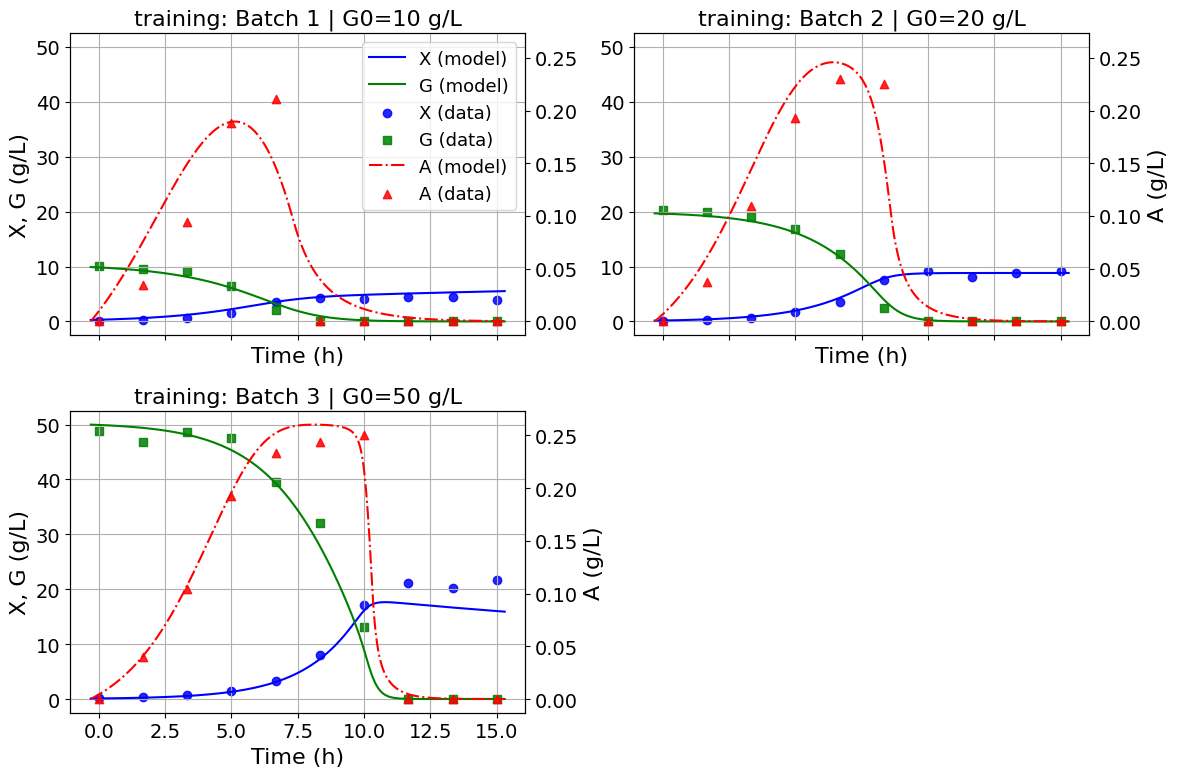

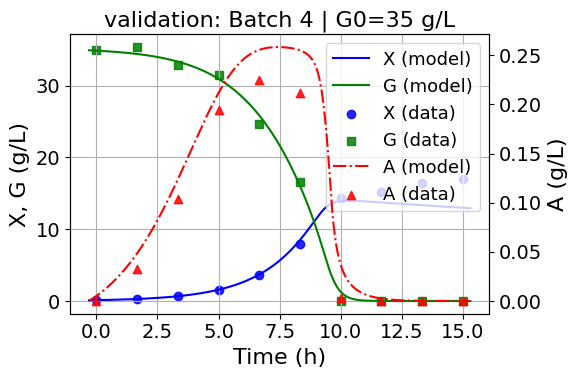

In [12]:
# --------------------------------------------------------
# 7. PLOTS (TRAIN 2x2 with learned ICs via log-offsets) +
#           (VALIDATION separate with measured ICs)
# --------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

# ====== Larger fonts ======
plt.rcParams.update({
    "font.size": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 13,
    "figure.titlesize": 18
})

def _dense_time_grid(t_batch_np, n_time_plot=800, pad_frac=0.02):
    t0 = float(np.min(t_batch_np))
    t1 = float(np.max(t_batch_np))
    if t1 <= t0:
        t1 = t0 + 1e-6
    span = t1 - t0
    t0p = t0 - pad_frac * span
    t1p = t1 + pad_frac * span
    return jnp.linspace(t0p, t1p, n_time_plot)

def _maybe_G0(orig_idx):
    """Return initial glucose G0 for original batch index, if available."""
    try:
        return initial_glucose[orig_idx]
    except Exception:
        return None

def _learned_ic_for_train_batch(params, idx):
    """
    Return learned ICs for TRAIN batch idx using log-offsets:
       X0 = X0_meas * exp(alpha_X),  G0 = G0_meas * exp(alpha_G),
       A0 = 0.0  (NOT estimated).
    Expects:
      params["ic_meas"]["X0"], params["ic_meas"]["G0"],
      params["ic_alpha"]["alpha_X"], params["ic_alpha"]["alpha_G"].
    """
    X0_meas = params["ic_meas"]["X0"][idx]
    G0_meas = params["ic_meas"]["G0"][idx]
    alpha_X = params["ic_alpha"]["alpha_X"][idx]
    alpha_G = params["ic_alpha"]["alpha_G"][idx]
    X0 = X0_meas * jnp.exp(alpha_X)
    G0 = G0_meas * jnp.exp(alpha_G)
    A0 = 0.0
    return float(X0), float(G0), float(A0)

def _measured_ic_for_batch(X_obs_np, G_obs_np):
    """
    Return measured (X0, G0) from first observation and enforce A0 = 0.0.
    """
    X0 = float(X_obs_np[0])
    G0 = float(G_obs_np[0])
    A0 = 0.0
    return X0, G0, A0

def plot_batches_grid(
    t_split, X_split, G_split, A_split, idxs_in_original,
    title_prefix, grid=(2, 2), start_batch_number=1,
    y_XG_limits=None, y_A_limits=None, n_time_plot=800, pad_frac=0.02,
    use_learned_ics=False
):
    """
    Plot batches in a grid. If use_learned_ics=True, use learned ICs with log-offsets (training).
    Otherwise, use measured ICs (validation). A(0) is always fixed to 0.0.

    Colors:
      X (biomass)  -> blue
      G (glucose)  -> green
      A (acetate)  -> red
    """
    n_batches = len(t_split)
    rows, cols = grid
    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows), sharex=True)
    axes = np.array(axes).reshape(rows, cols).flatten()

    net_params = params["net"]  # trained model weights

    # --- First pass: predictions + global limits ---
    cache = []
    XG_vals, A_vals = [], []

    for i in range(n_batches):
        t_i, X_i, G_i, A_i = t_split[i], X_split[i], G_split[i], A_split[i]
        t_obs_np = np.array(t_i)
        X_obs_np = np.array(X_i)
        G_obs_np = np.array(G_i)
        A_obs_np = np.array(A_i)

        # Time grid (dense)
        t_dense = _dense_time_grid(t_obs_np, n_time_plot=n_time_plot, pad_frac=pad_frac)

        # Initial conditions
        if use_learned_ics:
            # TRAINING: learned ICs per batch (position i within the split)
            X0_i, G0_i, A0_i = _learned_ic_for_train_batch(params, i)
        else:
            # VALIDATION: measured ICs from first observation (A0 fixed to 0.0)
            X0_i, G0_i, A0_i = _measured_ic_for_batch(X_obs_np, G_obs_np)

        # Predict on dense grid
        X_pred_d, G_pred_d, A_pred_d = predict(
            net_params, t_dense, X0_i, G0_i, A0=A0_i, train=False, masks=None
        )

        entry = {
            "t_obs": t_obs_np,
            "t_dense": np.array(t_dense),
            "X_obs": X_obs_np, "G_obs": G_obs_np, "A_obs": A_obs_np,
            "X_pred": np.array(X_pred_d), "G_pred": np.array(G_pred_d), "A_pred": np.array(A_pred_d),
            "orig_idx": idxs_in_original[i],
            "X0": X0_i, "G0": G0_i, "A0": A0_i
        }
        cache.append(entry)

        XG_vals.extend([X_obs_np, G_obs_np, entry["X_pred"], entry["G_pred"]])
        A_vals.extend([A_obs_np, entry["A_pred"]])

    def with_pad(vmin, vmax, frac=0.05):
        span = vmax - vmin
        if span == 0:
            base = max(abs(vmin), abs(vmax), 1.0)
            return vmin - base*frac, vmax + base*frac
        pad = span * frac
        return vmin - pad, vmax + pad

    if y_XG_limits is None:
        XG_lo, XG_hi = with_pad(min(np.min(v) for v in XG_vals), max(np.max(v) for v in XG_vals))
    else:
        XG_lo, XG_hi = y_XG_limits
    if y_A_limits is None:
        A_lo, A_hi = with_pad(min(np.min(v) for v in A_vals), max(np.max(v) for v in A_vals))
    else:
        A_lo, A_hi = y_A_limits

    # --- Second pass: plot ---
    for i, entry in enumerate(cache):
        if i >= rows*cols:
            break
        ax1 = axes[i]; ax2 = ax1.twinx()
        ax1.set_ylim(XG_lo, XG_hi); ax2.set_ylim(A_lo, A_hi)

        # Model curves
        ax1.plot(entry["t_dense"], entry["X_pred"], '-',  color='b', label='X (model)')
        ax1.plot(entry["t_dense"], entry["G_pred"], '-',  color='g', label='G (model)')
        ax2.plot(entry["t_dense"], entry["A_pred"], '-.', color='r', label='A (model)')

        # Data
        ax1.scatter(entry["t_obs"], entry["X_obs"], marker='o', color='b', alpha=0.85, label='X (data)')
        ax1.scatter(entry["t_obs"], entry["G_obs"], marker='s', color='g', alpha=0.85, label='G (data)')
        ax2.scatter(entry["t_obs"], entry["A_obs"], marker='^', color='r', alpha=0.85, label='A (data)')

        # Title (batch number and G0 if available) + prefix
        batch_number = start_batch_number + i
        G0_val = _maybe_G0(entry["orig_idx"])
        prefix = f"{title_prefix}: " if title_prefix else ""
        if G0_val is not None:
            ax1.set_title(f"{prefix}Batch {batch_number} | G0={G0_val} g/L")
        else:
            ax1.set_title(f"{prefix}Batch {batch_number}")

        # Labels
        if i % cols == 0:
            ax1.set_ylabel("X, G (g/L)")
        if (i % cols == cols-1) or (i == len(cache)-1):
            ax2.set_ylabel("A (g/L)")
        ax1.set_xlabel("Time (h)")
        ax1.grid(True)

        # Legend once
        if i == 0:
            l1, lb1 = ax1.get_legend_handles_labels()
            l2, lb2 = ax2.get_legend_handles_labels()
            ax1.legend(l1 + l2, lb1 + lb2, loc="upper right")

    # Hide unused cells
    for j in range(len(cache), rows*cols):
        axes[j].axis('off')

    fig.tight_layout()
    return fig

# ------------------------
# CALLS (TRAIN uses learned log-offset ICs; VALIDATION uses measured ICs; A0=0 in both)
# ------------------------

# Training in a 2x2 grid, numbering from 1; learned ICs (A0=0)
train_fig = plot_batches_grid(
    t_train, X_train, G_train, A_train,
    idxs_in_original=train_idxs,
    title_prefix="training",
    grid=(2, 2),
    start_batch_number=1,
    n_time_plot=800,
    use_learned_ics=True
)
plt.show()

# Last training batch number:
last_train_number = 1 + len(t_train) - 1

# Validation separate figure; measured ICs (A0=0); continue numbering
val_fig = plot_batches_grid(
    t_valid, X_valid, G_valid, A_valid,
    idxs_in_original=valid_idxs,
    title_prefix="validation",
    grid=(1, 1),
    start_batch_number=last_train_number + 1,
    n_time_plot=800,
    use_learned_ics=False
)
plt.show()


### Description of the network output plots

This code visualizes the **outputs of the neural network** trained within the hybrid model framework.  
It helps inspect how the learned functions behave with respect to the state variables **X**, **G**, and **A**.

Only **data points for which we have experimental observations** are plotted — ensuring that the analysis reflects the actual range of measured conditions.

- **Figure 1** shows a 4×3 grid:
  - Each row corresponds to one network output: \(f_1, f_2, f_3,\) and \(g_3)\).
  - Each column corresponds to one input variable: \(X\), \(G\), and \(A\).
  - This allows visual inspection of how each learned function varies with the inputs.

- **Figure 2** displays \(g_3\) versus \(f_1\), highlighting how the non-negative output \(g_3\) relates to the inferred specific growth rate function \(f_1\).

These plots provide a compact way to verify that the neural network captures biologically meaningful relationships within the observed data range.


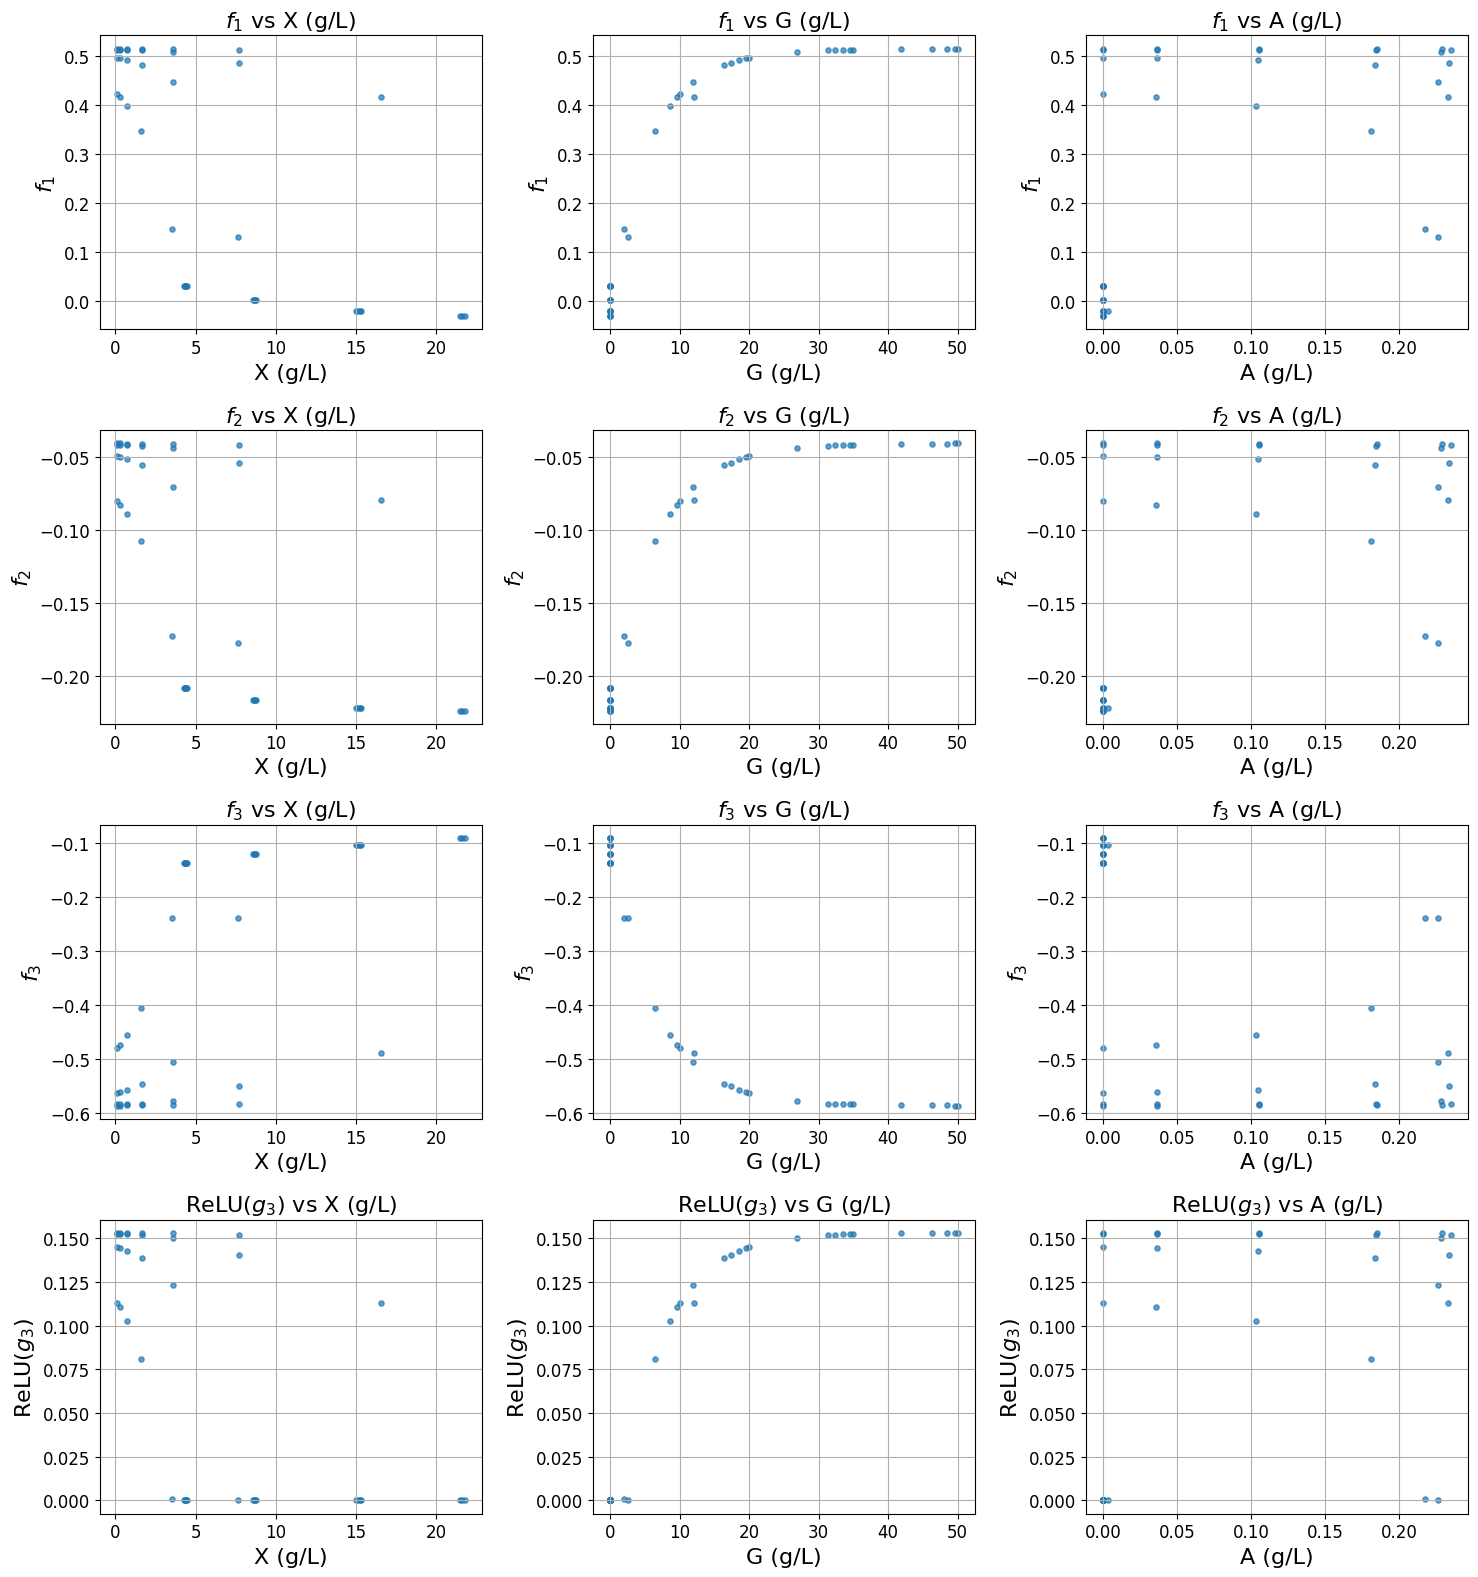

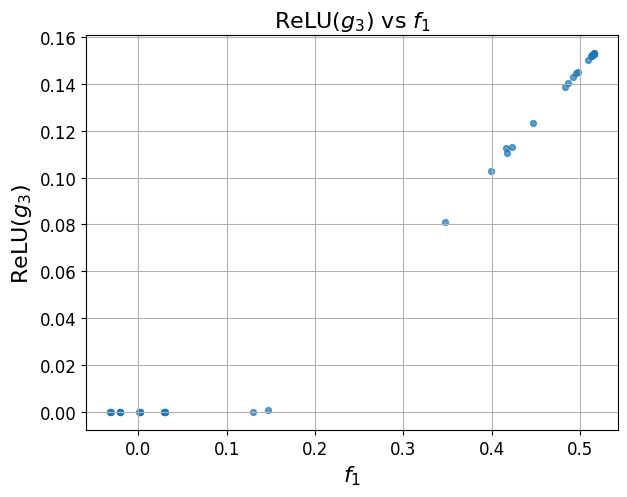

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

def plot_network_outputs(params, neural_network, raw_X, raw_G, raw_A):
    """
    Visualize network outputs (f1, f2, f3, g3) against inputs (X, G, A).
    - We also plot ReLU(g3) = max(g3, 0) for nonnegative-only views.
    - Figure 1: 4x3 grid with (f1, f2, f3, ReLU(g3)) vs (X, G, A).
    - Figure 2: ReLU(g3) vs f1.

    Args
    ----
    params : dict with at least params["net"] (network weights)
    neural_network : fn(net_params, y, train=False, masks=None) -> (f1,f2,f3,g3)
    raw_X, raw_G, raw_A : lists of batches (each batch = 1D array/list) for X, G, A
    """

    # ====== Larger fonts ======
    plt.rcParams.update({
        "font.size": 14,
        "axes.titlesize": 16,
        "axes.labelsize": 16,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 12,
        "figure.titlesize": 18
    })

    # 1) Flatten batch lists -> 1D arrays (and remove any NaNs if present)
    X_data = np.concatenate([np.asarray(b).ravel() for b in raw_X])
    G_data = np.concatenate([np.asarray(b).ravel() for b in raw_G])
    A_data = np.concatenate([np.asarray(b).ravel() for b in raw_A])

    mask = np.isfinite(X_data) & np.isfinite(G_data) & np.isfinite(A_data)
    X_data, G_data, A_data = X_data[mask], G_data[mask], A_data[mask]

    # 2) Batch evaluation via vmap
    net_params = params["net"]

    def _forward(y):
        # y: shape (3,) -> returns (f1, f2, f3, g3)
        return neural_network(net_params, y, train=False, masks=None)

    Y = jnp.stack([jnp.asarray(X_data), jnp.asarray(G_data), jnp.asarray(A_data)], axis=1)  # (N,3)
    f1_vals, f2_vals, f3_vals, g3_raw = jax.vmap(_forward)(Y).T  # each has shape (N,)

    # 3) ReLU(g3) for plots that require non-negativity
    g3_vals = jnp.maximum(g3_raw, 0.0)

    # 4) Figure 1: 4x3 grid -> (f1,f2,f3,ReLU(g3)) vs (X,G,A)
    fig, axes = plt.subplots(4, 3, figsize=(15, 16), sharex=False, sharey=False)
    axes = np.asarray(axes)

    inputs = [
        (X_data, 'X (g/L)'),
        (G_data, 'G (g/L)'),
        (A_data, 'A (g/L)')
    ]
    funcs = [
        (np.asarray(f1_vals), r'$f_1$'),
        (np.asarray(f2_vals), r'$f_2$'),
        (np.asarray(f3_vals), r'$f_3$'),
        (np.asarray(g3_vals), r'$\mathrm{ReLU}(g_3)$')
    ]

    for row, (f_vals, f_label) in enumerate(funcs):
        for col, (inp_vals, xlabel) in enumerate(inputs):
            ax = axes[row, col]
            ax.scatter(inp_vals, f_vals, alpha=0.7, s=14)
            ax.set_xlabel(xlabel)
            ax.set_ylabel(f_label)
            ax.set_title(f'{f_label} vs {xlabel}')
            ax.grid(True)

    fig.tight_layout()
    plt.show()

    # 5) Figure 2: ReLU(g3) vs f1
    plt.figure(figsize=(6.5, 5.2))
    plt.scatter(np.asarray(f1_vals), np.asarray(g3_vals), alpha=0.7, s=18)
    plt.xlabel(r'$f_1$')
    plt.ylabel(r'$\mathrm{ReLU}(g_3)$')
    plt.title(r'$\mathrm{ReLU}(g_3)$ vs $f_1$')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_network_outputs(params, neural_network, raw_X, raw_G, raw_A)
